In [1]:
from tqdm import tqdm
import librosa as lb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os
import pickle as pkl
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [13]:
feature_types = ['mfcc', 'lfcc', 'spec', 'stft']
feature_type = 'spec' #Put name of chosen preprocessing method, you can add in feature_extraction_functions.py

model_types = ['ann_model_1']
model_type = 'ann_model_1' #Put name of chosen training model, you can add in models.py




model_checkpoint_filepath = f'./models/{feature_type}_{model_type}.h5'

training_history_filepath = f"./models/{feature_type}_{model_type}_train_history.pkl"

extracted_data_filepath = f"./feature_extraction_data/{feature_type}_USD_Folds.pkl"

model_checkpoint_filepath, training_history_filepath, extracted_data_filepath

('./models/spec_ann_model_1.h5',
 './models/spec_ann_model_1_train_history.pkl',
 './feature_extraction_data/spec_USD_Folds.pkl')

In [3]:
re_train = True #Train Model Again
re_feature_extract = False #Feature Extract Again

EPOCHS = 100
BATCH_SIZE = 64

In [4]:
##################################################
#''''''''''''''''''''''''''''''''''''''''''''''''#
#''''''''''''''' DATA PROCESSING ''''''''''''''''#
#''''''''''''''''''''''''''''''''''''''''''''''''#
##################################################

In [5]:
df = pd.read_csv('UrbanSound8K.csv')

In [14]:
from feature_extraction_functions import spectrogram_feature_extractor, lfcc_feature_extractor, mfcc_feature_extractor, stft_feature_extractor

def extract_data(feature_type, feature_extractor):
    x, y = [], []

    for i,rows in tqdm(df.iterrows()):
        path = '../data/UrbanSoundDatabaseFolds/' + 'fold' + str(rows['fold']) + '/' + str(rows['slice_file_name'])

        x.append(feature_extractor(path))
        y.append(rows['classID'])
    
    x = np.array(x)
    y = np.array(y)
    y = to_categorical(y)

    #saving to pickle
    with open(extracted_data_filepath, 'wb') as file:
        pkl.dump((x, y), file)
        

'''
IMPORTANT: IF EXTRACTING DATA, PUT THE MATCHING EXTRACTOR FUNCTION AS 2ND ARGUMENT IN EXTRACT_DATA
'''


#If you want to re extract data or the extracted data does not exist
if re_feature_extract == True or not os.path.exists(extracted_data_filepath):
    print(f" EXTRACTING {feature_type} DATA TO {extracted_data_filepath}")
    extract_data(feature_type, spectrogram_feature_extractor)



#If you do not want to re train data and extracted data exists
else:
    with open(extracted_data_filepath, 'rb') as f:
        print(f" LOADING {feature_type} DATA FROM {extracted_data_filepath}")
        (x, y) = pkl.load(f)
        
print(f"SHAPE OF DATA: {x.shape, y.shape}")


 LOADING spec DATA FROM ./feature_extraction_data/spec_USD_Folds.pkl
SHAPE OF DATA: ((8732, 65), (8732, 10))


In [15]:
from sklearn.model_selection import train_test_split

xtrainval, X_test, ytrainval, y_test = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
X_train, X_val, y_train, y_val = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',X_train.shape[0])
print('Number of samples for Validation set :',X_val.shape[0])
print('Number of samples for Test set :', X_test.shape[0])


Number of samples for Train set : 6286
Number of samples for Validation set : 1572
Number of samples for Test set : 874


In [8]:
##################################################
#''''''''''''''''''''''''''''''''''''''''''''''''#
#''''''''''''''''''''TRAINING '''''''''''''''''''#
#''''''''''''''''''''''''''''''''''''''''''''''''#
##################################################

In [9]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [16]:
from models import ann_model_1

'''
IMPORTANT: Replace "model = X" with the matching model chosen at the vars at the top
'''
model = ann_model_1(input_shape=(65,))


#Arguments can be changed optimization
checkpoint = ModelCheckpoint(filepath=model_checkpoint_filepath, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             monitor='val_accuracy', 
                             mode='max', 
                             verbose=1)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              66000     
_________________________________________________________________
dense_8 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
#If model exists and you do not want to re train it
if os.path.exists(model_checkpoint_filepath) and re_train == False:
    model = load_model(model_checkpoint_filepath)
    
    with open(training_history_filepath, 'rb') as f:
        training = pkl.load(f)
    
    print("* * * Loading Model and Training History * * *")
    
#If model doesn't exist or you want to retrain it
else: 
    print("* * * Training Model * * *")
    
    training = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=64, callbacks=checkpoint)
    with open(training_history_filepath, 'wb') as f:
        pkl.dump(training.history, f)
        
    

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

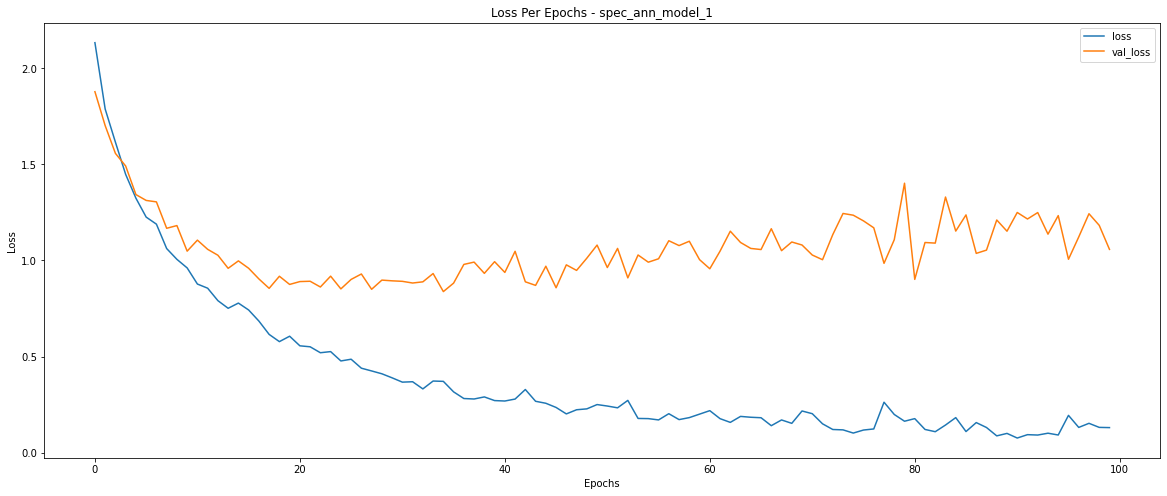

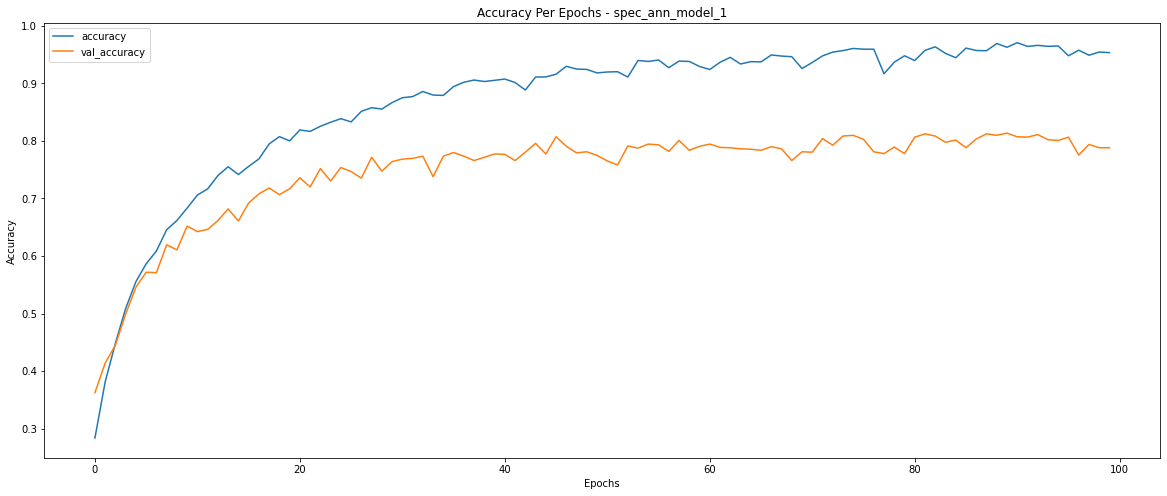

In [20]:
if os.path.exists(model_checkpoint_filepath) and re_train == False:
    train_hist = pd.DataFrame(training)
else:
    train_hist = pd.DataFrame(training.history)
    

plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title(f'Loss Per Epochs - {feature_type}_{model_type}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title(f'Accuracy Per Epochs - {feature_type}_{model_type}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

c:\Users\Max Xiao\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


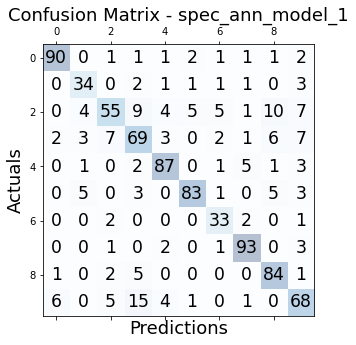

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

#changing model predictions to one hot encodings
y_pred = to_categorical(model.predict_classes(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

#confusion matrixd
conf_matrix = confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix - {feature_type}_{model_type}', fontsize=18)
plt.show()

In [27]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)

print("F1 Score:", fscore)
print('Precision:', precision)
print('Recall:', recall)

F1 Score: [0.90452261 0.75555556 0.63583815 0.66990291 0.86138614 0.86458333
 0.79518072 0.90731707 0.84       0.68686869]
Precision: [0.90909091 0.72340426 0.75342466 0.6509434  0.85294118 0.90217391
 0.73333333 0.88571429 0.78504673 0.69387755]
Recall: [0.9        0.79069767 0.55       0.69       0.87       0.83
 0.86842105 0.93       0.90322581 0.68      ]
